In [1]:
def sector_data(sector_page_link):
    import requests
    from bs4 import BeautifulSoup

    response = requests.get(sector_page_link)
    results_page = BeautifulSoup(response.content, 'lxml')
    
    sector_change = results_page.find('div', class_='tab-content-wrapper').find_all('span')[1].get_text()
    sector_market_cap = results_page.find('div', class_='tab-content-wrapper').find_all('span')[3].get_text()
    sector_market_weight = results_page.find('div', class_='tab-content-wrapper').find_all('span')[5].get_text()
    
    return sector_change, sector_market_cap, sector_market_weight

def sector_performance():
    import requests
    from bs4 import BeautifulSoup
    import pandas as pd

    stats_list = list()
    sector_list = list()
    measure_list = list()

    url = "https://eresearch.fidelity.com/eresearch/goto/markets_sectors/landing.jhtml"

    results_page = requests.get(url)
    soup = BeautifulSoup(results_page.content, 'lxml')
    all_performance = soup.find_all('a', class_='heading1')

    for sectors in all_performance:
        name = sectors.find('strong').get_text()
        link = "https://eresearch.fidelity.com" + sectors.get('href')
        change, mktcap, mktwgt = sector_data(link)
        stats_list.append((change, mktcap, mktwgt))
        sector_list.append(name)

    measure_list = 'Sector_Change', 'Market_Capital', 'Market_Weight'
    sector_table = pd.DataFrame(stats_list, index = sector_list, columns = measure_list)
    
    return sector_table
sector_performance()

,Sector_Change,Market_Capital,Market_Weight
Communication Services,+0.07%,$4.46T,9.80%
Consumer Discretionary,-0.32%,$4.73T,9.73%
Consumer Staples,+0.20%,$3.41T,7.50%
Energy,+0.72%,$3.47T,5.51%
Financials,-0.72%,$7.16T,13.82%
Health Care,+0.60%,$5.66T,15.61%
Industrials,-0.03%,$3.89T,9.51%
Information Technology,-0.86%,$6.85T,19.70%
Materials,+0.58%,$1.76T,2.67%
Real Estate,+0.29%,$1.20T,2.95%


In [194]:
stock = input('Enter a stock ticker: ').upper()

Enter a stock ticker: xnet


In [195]:
def get_sector(ticker):
    import requests
    from bs4 import BeautifulSoup
    url = 'https://finance.yahoo.com/quote/' + ticker + '/profile?p=' + ticker

    response = requests.get(url)
    results_page = BeautifulSoup(response.content, 'lxml')
    profile = results_page.find('div', class_='asset-profile-container')
    sector = profile.find_all('strong')[0].get_text()
    industry = profile.find_all('strong')[1].get_text()

    return sector, industry
get_sector(stock)

('Technology', 'Software - Application')

### Find competitors

In [196]:
def get_competitors(ticker):
    import requests
    from bs4 import BeautifulSoup
    url = 'https://www.nasdaq.com/symbol/' + ticker + '/stock-comparison'

    response = requests.get(url)
    results_page = BeautifulSoup(response.content, 'lxml')
    table = results_page.find('div', class_='genTable thin')
    competitors = list()
    for i in range(4):
        competitors.append(table.find_all('input')[i].get('value'))
    
    return competitors
get_competitors(stock)

['MSFT', 'ORCL', 'ADBE', 'CRM']

In [197]:
def get_financial_stats(ticker):
    import requests
    from bs4 import BeautifulSoup
    url = "https://finance.yahoo.com/quote/" + ticker + "/key-statistics?p=" + ticker
    
    response = requests.get(url)
    results_page = BeautifulSoup(response.content,'lxml')
    stats_lists = results_page.find_all('table')
    test_list = list()
    for i in stats_lists:
        stat_name = i.find_all('span')
        stock_stat = i.find_all('td',class_='Fz(s) Fw(500) Ta(end)')
        for j in range(len(stock_stat)):
            if not stat_name[j].get_text() == 'N/A':
                test_list.append((stat_name[j].get_text(),stock_stat[j].get_text()))
    return test_list

In [198]:
def get_row(ticker,measure_list):
    from pandas_datareader import data as web
    a = get_financial_stats(ticker)
    row = list()
    row.append(web.DataReader(ticker,"yahoo").iloc[-1,3])
    for i in measure_list:
        if not i == "Price":
            appended = 0
            for j in a:
                if j[0] == i:
                    row.append(j[1])
                    appended = 1
            if appended == 0:
                row.append('N/A')   
    return row

In [223]:
def competitor(ticker):
    import numpy as np

    r = get_competitors(ticker)
    r.insert(0, ticker)

    m = list((s,a,b,c,d))
    for i in range(0,len(r)):
        if get_row(r[i],['Market Cap (intraday)'])[1][-1] == 'B':
            m[i] = float(get_row(r[i],['Market Cap (intraday)'])[1][:-1])
        elif get_row(r[i],['Market Cap (intraday)'])[1][-1] == 'M':
            m[i] = float(get_row(r[i],['Market Cap (intraday)'])[1][:-1]) / 1000
        elif get_row(r[i],['Market Cap (intraday)'])[1][-1] == 'T':
            m[i] = float(get_row(r[i],['Market Cap (intraday)'])[1][:-1]) * 1000

    diff = list()
    for i in range(1,len(r)):
        diff.append(abs(m[0]-m[i]))

    competitor = r[np.argmin(diff)+1]
    return competitor
competitor(stock)

0.34137 851.22
0.34137 184.73
0.34137 122.47
0.34137 108.03
[850.87863, 184.38862999999998, 122.12863, 107.68863]


'CRM'

### Comparison Table

In [200]:
def comp_stat_table(ticker):
    import pandas as pd
    measure_list = ['Price','Market Cap (intraday)','Diluted EPS','Book Value Per Share','Quarterly Revenue Growth','Quarterly Earnings Growth','Trailing Annual Dividend Yield','5 Year Average Dividend Yield','Payout Ratio','Trailing P/E','PEG Ratio (5 yr expected)','Beta (3Y Monthly)']
    r = get_competitors(ticker)
    r.insert(0, ticker)

    s_row = get_row(ticker,measure_list)
    a_row = get_row(r[1],measure_list)
    b_row = get_row(r[2],measure_list)
    c_row = get_row(r[3],measure_list)
    d_row = get_row(r[4],measure_list)

    stats_list = [s_row,a_row,b_row,c_row,d_row]
    final_table = pd.DataFrame(stats_list,index = r,columns = measure_list)

    return final_table
comp_stat_table(stock)

,Price,Market Cap (intraday),Diluted EPS,Book Value Per Share,Quarterly Revenue Growth,Quarterly Earnings Growth,Trailing Annual Dividend Yield,5 Year Average Dividend Yield,Payout Ratio,Trailing P/E,PEG Ratio (5 yr expected),Beta (3Y Monthly)
XNET,5.080000,341.37M,-0.05,N/A,1.10%,N/A,N/A,N/A,N/A,N/A,0.91,2.49
MSFT,110.889999,851.22B,2.43,11.19,18.50%,34.20%,1.56%,2.31,69.14%,45.67,1.75,1.09
ORCL,48.759998,184.73B,0.95,9.99,1.00%,5.60%,1.59%,1.37,78.35%,51.43,1.73,1.05
ADBE,250.889999,122.47B,4.84,18.12,24.40%,58.80%,N/A,1/2,N/A,51.85,1.01,1.03
CRM,142.759995,108.03B,0.96,17.88,27.30%,550.00%,N/A,1/4,N/A,148.86,1.68,1.40


In [177]:
def get_prices(ticker):
    import datetime
    import dateutil.relativedelta
    import numpy as np
    import pandas_datareader.data as web

    stocks = ticker, get_competitors(ticker)
    five_years_ago = (datetime.date.today() - dateutil.relativedelta.relativedelta(years=5)).strftime('%Y-%m-%d')
    today = datetime.date.today().strftime('%Y-%m-%d')

    prices = web.DataReader(np.hstack(('SPY',)+stocks),'yahoo',five_years_ago,today)['Adj Close']
    return prices

Symbols
DRI     0.407171
MCD     0.500260
QSR     0.505535
SBUX    0.543287
SPY     1.000000
YUM     0.557694
Name: SPY, dtype: float64


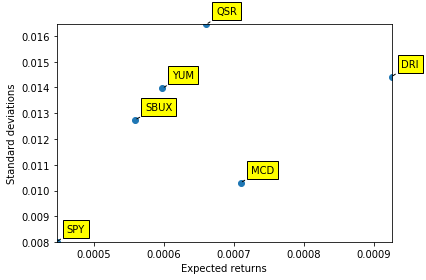

In [193]:

import matplotlib.pyplot as plt
%matplotlib inline
import pylab as plot

returns = get_prices(stock).pct_change()
print(returns.corr()['SPY']) # correlation between each stock and S&P 500

plt.xlabel('Expected returns')
plt.ylabel('Standard deviations')
for label,x,y in zip(returns.columns,returns.mean(),returns.std()):
    plt.annotate(
        label, 
        xy = (x,y),
        xytext = (10,10),
        textcoords = 'offset points',
        bbox = dict(fc = 'yellow'),
        arrowprops = dict(arrowstyle = '-')
    )
plot.ylim([min(returns.std()),max(returns.std())])
plot.xlim([min(returns.mean()),max(returns.mean())])
print(plt.scatter(returns.mean(), returns.std()))

In [178]:
def plot_prices(ticker):
    import statsmodels.api as sm
    import matplotlib.patches as mpatches
    import pylab as plot

    p = get_prices(ticker)
    x = p['SPY']
    x = sm.add_constant(x)
    y = p[ticker]
    model = sm.OLS(y,x,missing='drop')
    regression = model.fit()
    print(regression.summary())
    
    fig,ax = plt.subplots(figsize=(20,10))
    blue_patch = mpatches.Patch(color='blue', label=ticker)
    orange_patch = mpatches.Patch(color='orange', label='S&P 500 (Fitted Value)')
    plt.legend(handles=[blue_patch,orange_patch])
    params = {'legend.fontsize': 15, 'legend.handlelength': 2}
    plot.rcParams.update(params)

    ax.plot(y)
    ax.plot(regression.fittedvalues)

                            OLS Regression Results                            
Dep. Variable:                   SBUX   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     928.2
Date:                Sat, 01 Dec 2018   Prob (F-statistic):          3.76e-153
Time:                        16:52:52   Log-Likelihood:                -4200.8
No. Observations:                1260   AIC:                             8406.
Df Residuals:                    1258   BIC:                             8416.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.0164      1.155     13.004      0.0

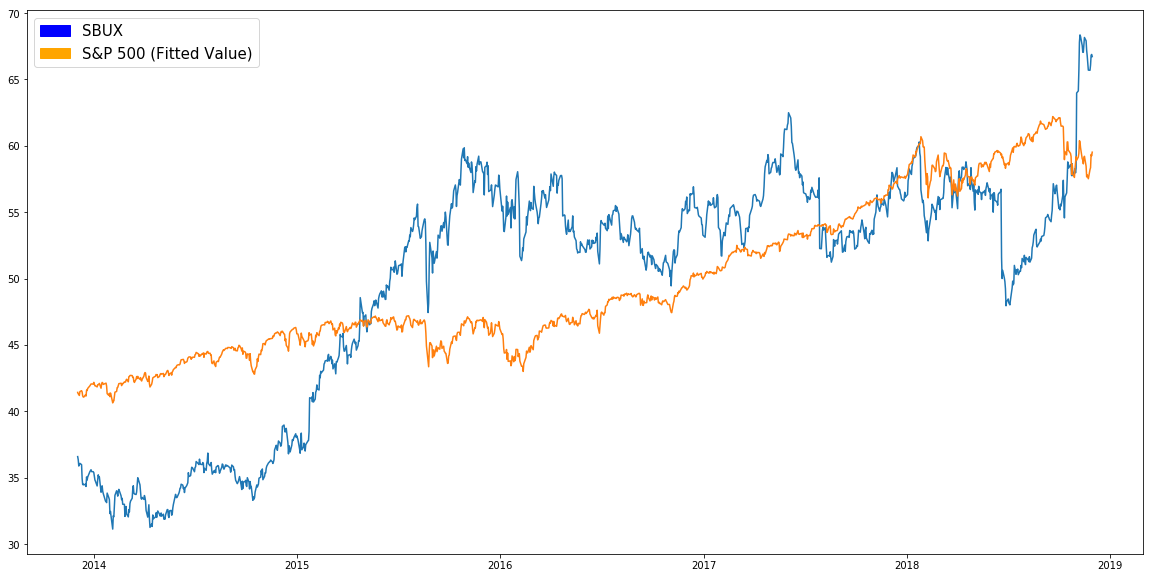

In [179]:
plot_prices(stock)

                            OLS Regression Results                            
Dep. Variable:                    IBM   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.332
Date:                Sat, 01 Dec 2018   Prob (F-statistic):              0.127
Time:                        16:53:11   Log-Likelihood:                -4944.2
No. Observations:                1260   AIC:                             9892.
Df Residuals:                    1258   BIC:                             9903.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        139.4242      2.083     66.930      0.0

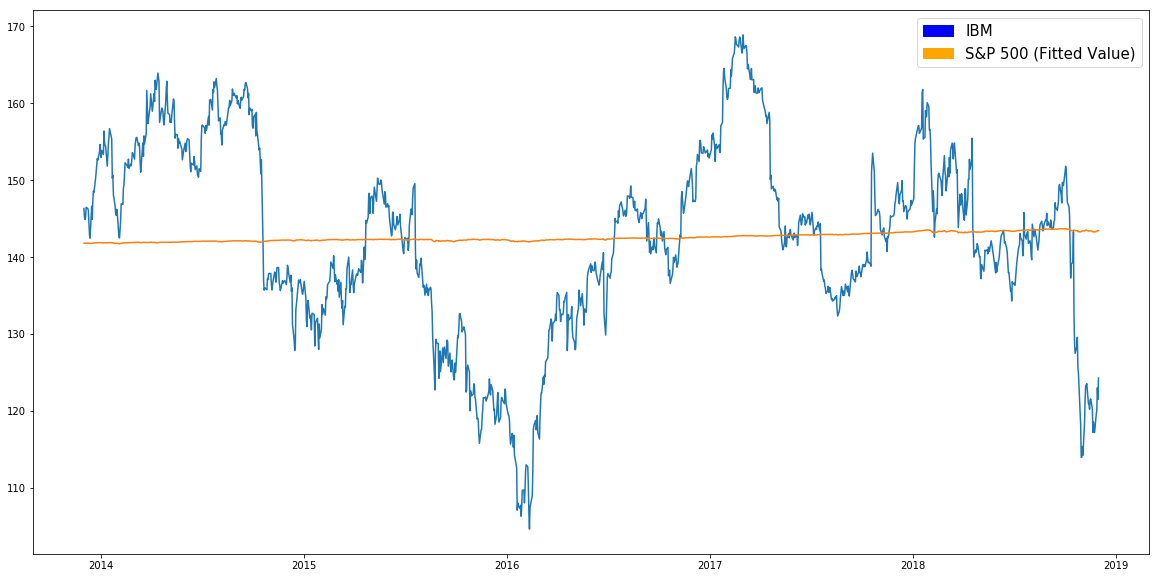

In [180]:
plot_prices('IBM')

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     928.2
Date:                Sat, 01 Dec 2018   Prob (F-statistic):          3.76e-153
Time:                        16:37:28   Log-Likelihood:                -4200.8
No. Observations:                1260   AIC:                             8406.
Df Residuals:                    1258   BIC:                             8416.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.0164      1.155     13.004      0.0

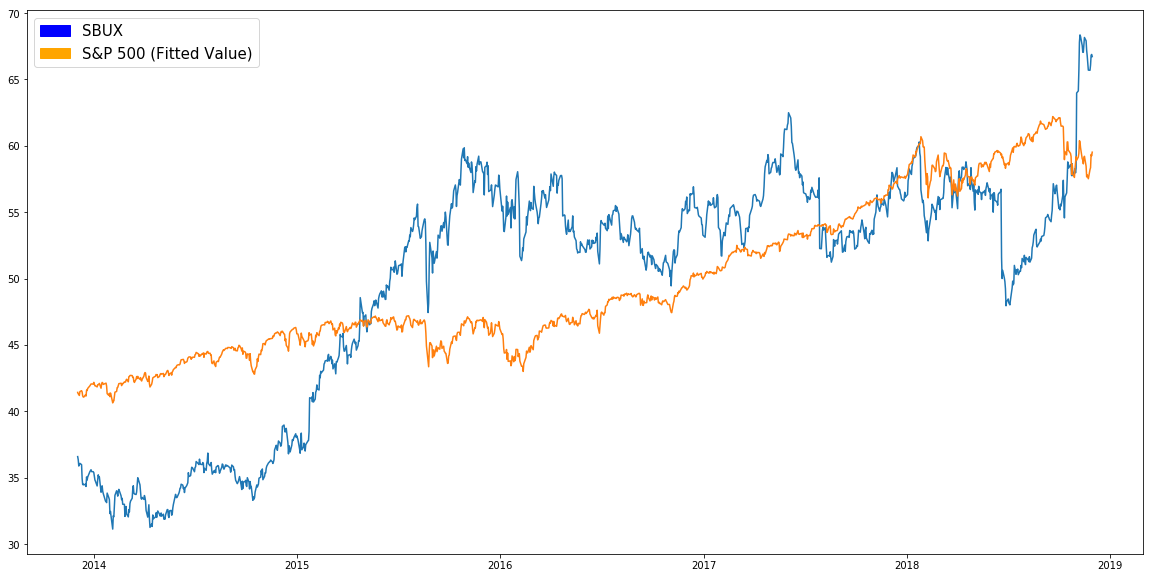

In [154]:
plot_prices('SBUX')